# Mapping to Pre-built Symphony References

In this tutorial, we will show how to map new query datasets onto pre-built Symphony references.

**Pre-built references available for download:**

| Reference atlas | File | Num cells | Description
| --- | ----------- | --------- | ----
|  Atlas of 10x PBMCs | pbmcs_10x_reference.rds | 20,792 cells | Sequenced with three 10x protocols (3'v1, 3'v2, and 5')
| Atlas of human pancreatic islet cells | pancreas_plate-based_reference.rds | 5,887 cells, 32 donors | From four separate studies
| Atlas of human fetal liver hematopoeisis | fetal_liver_reference_3p.rds | 113,063 cells, 14 donors | From Popescu et al. (*Nature* 2019), sequenced with 10x 3' chemistry
| Multimodal atlas of Memory T cells | -- | 500,089 cells, 271 samples | CITE-seq; to be released upon publication

To read in a reference into R, one may simply execute: `reference = readRDS('path/to/reference_name.rds')`

Note: In order to map query cells onto the reference UMAP coordinates (e.g. to visualize reference and query cells together), you will need to save the path to the corresponding reference uwot_model file in the reference object's reference$save_uwot_path slot in order to load the uwot model for query mapping. This is due to a technicality of how the uwot package saves and loads UMAP models. If you only wish to map the query cells into the harmonized reference embedding (and compute your own separate UMAP embedding for visualization), you may ignore this step.

## Imports

Visit https://github.com/immunogenomics/symphony for information about installing Symphony.

In [1]:
#devtools::install_github("immunogenomics/symphony", dep = FALSE) # whether to update dependencies

In [2]:
suppressPackageStartupMessages({
    library(symphony)
    library(harmony)
    library(singlecellmethods)
    library(tidyverse)
    library(data.table)
    library(matrixStats)
    library(Matrix)
    library(uwot)
    library(plyr)
    library(dplyr)
    library(class) # for k-NN
    
    # Plotting
    library(ggplot2)
    library(ggthemes)
    library(ggrastr)
    library(ggrepel)
    library(RColorBrewer)
    library(patchwork)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

# Mapping to 10x PBMCs atlas

## Load and view the reference

## Map an example query dataset

# Mapping to pancreatic islet atlas

## Load and view the reference

In [3]:
# Read in saved reference
reference_pancreas = readRDS('../pre-built_references/pancreas_plate-based_reference.rds')

In [4]:
celltype.colors = c('alpha'="#ed2bb1",
                    'beta'="#239eb3",
                    'gamma'="#d1bfec",
                    'delta'= "#FF6347",
                    'stellate'="#11e38c",
                    'immune'="#812050",
                    'ductal'="#b2d27a",
                    'endothelial'="#4e2da6",
                    'acinar'="#f6bb86",
                    'schwann'="#115d52",
                    'epsilon'="#a1def0",
                    'mast'="#8fec2f")

Adding missing grouping variables: `cell_type`


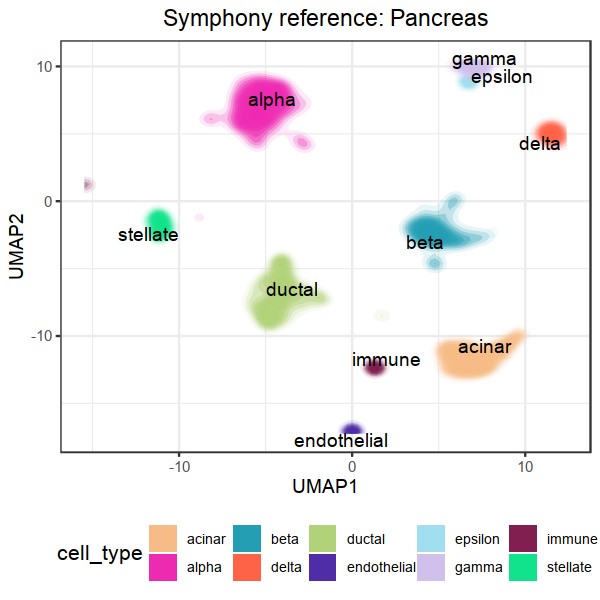

In [5]:
fig.size(5, 5)
p = plotReference(reference_pancreas,
                   as.density = TRUE,      # plot density or individual cells
                   bins = 10,              # if density, nbins parameter for stat_density_2d
                   bandwidth = 1.5,        # if density, bandwidth parameter for stat_density_2d
                   title = "Symphony reference: Pancreas",    # Plot title
                   color.by = 'cell_type', # metadata column name for cell type labels
                   celltype.colors = celltype.colors, # custom color palette
                   show.legend = TRUE,     # Show cell type legend
                   show.labels = TRUE,     # Show cell type labels
                   show.centroids = FALSE) # Plot soft cluster centroid locations)
p

## Map an example query dataset

The mouse expression was "humanized" using a custom ortholog mapping (`../data/Fig4_pancreas_multi/ensembl_homologene_human-to-mouse_mapping.rds`) generated from combining ortholog pairs from Ensembl (accessed via biomaRt) and Homologene.

Obtained NCBI Homologene mapping from: https://ftp.ncbi.nih.gov/pub/HomoloGene/build37.2/homologene.data

In [6]:
# Read in normalized expression for human and mouse
human_exp_norm = readRDS('../data/Fig4_pancreas_multi/baron_human_exp.rds')
mouse_exp_norm = readRDS('../data/Fig4_pancreas_multi/baron_mouse_biomart_homologene_exp.rds')

# Read in metadata
human_metadata = readRDS('../data/Fig4_pancreas_multi/baron_human_metadata.rds')
mouse_metadata = readRDS('../data/Fig4_pancreas_multi/baron_mouse_metadata.rds')
human_metadata$species_donor = paste0(human_metadata$species, human_metadata$donor)
mouse_metadata$species_donor = paste0(mouse_metadata$species, mouse_metadata$donor)

In [7]:
dim(human_exp_norm)
human_metadata %>% head(4)
dim(mouse_exp_norm)
mouse_metadata %>% head(4)

[1] 20125  8569

,donor,cell_type1,total_features,cell_type,species,dataset,species_donor
,<dbl>,<fct>,<int>,<fct>,<chr>,<chr>,<chr>
human1_lib1.final_cell_0001,1,acinar,3526,acinar,human,inDrop,human1
human1_lib1.final_cell_0002,1,acinar,4201,acinar,human,inDrop,human1
human1_lib1.final_cell_0003,1,acinar,2119,acinar,human,inDrop,human1
human1_lib1.final_cell_0004,1,acinar,2956,acinar,human,inDrop,human1


[1] 20873  1886

,donor,cell_type1,total_features,cell_type,species,dataset,species_donor
,<dbl>,<fct>,<int>,<fct>,<chr>,<chr>,<chr>
mouse1_lib1.final_cell_0001,1,beta,3205,beta,mouse,inDrop,mouse1
mouse1_lib1.final_cell_0002,1,ductal,3829,ductal,mouse,inDrop,mouse1
mouse1_lib1.final_cell_0003,1,delta,2582,delta,mouse,inDrop,mouse1
mouse1_lib1.final_cell_0004,1,schwann,3041,schwann,mouse,inDrop,mouse1


In [8]:
human_exp_norm[1:5, 1:2]
mouse_exp_norm[1:5, 1:2]

5 x 2 sparse Matrix of class "dgCMatrix"
       human1_lib1.final_cell_0001 human1_lib1.final_cell_0002
A1BG                      .                                  .
A1CF                      1.024161                           .
A2M                       .                                  .
A2ML1                     .                                  .
A4GALT                    .                                  .

5 x 2 sparse Matrix of class "dgCMatrix"
         mouse1_lib1.final_cell_0001 mouse1_lib1.final_cell_0002
13CDNA73                           .                           .
15E1.2                             .                           .
182-FIP                            .                           .
3'HEXO                             .                           .
384D8-2                            .                           .

In [9]:
# To map the human and mouse simultaneously, combine the two sparse matrices
combined_filled <- t(plyr::rbind.fill.matrix(t(mouse_exp_norm), t(human_exp_norm)))
combined_filled[is.na(combined_filled)] = 0 # fill in any missing genes with 0
colnames(combined_filled) = c(rownames(mouse_metadata), rownames(human_metadata))

In [10]:
# Symphony mapping
system.time({
query= mapQuery(exp_query = combined_filled, 
                        metadata_query = rbind(mouse_metadata, human_metadata),
                        ref_obj = reference_pancreas,
                        vars = c('dataset', 'species', 'species_donor'), 
                        do_normalize = FALSE)
})

Scaling and synchronizing query gene expression
Found 2236 reference variable genes in query dataset
Project query cells using reference gene loadings
Clustering query cells to reference centroids
Correcting query batch effects
UMAP
All done!


   user  system elapsed 
 13.736   5.978   9.092 

## Plot query after mapping

Plot query in reference UMAP coordinates

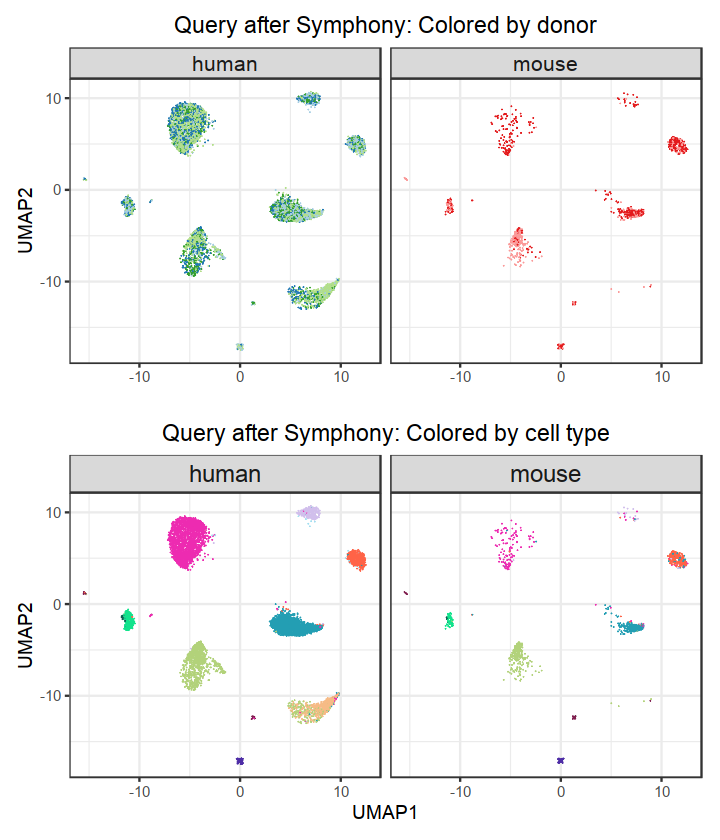

In [11]:
fig.size(7, 6)

# Add UMAP coordinates
colnames(query$umap) = c('UMAP1', 'UMAP2')
umap_labels = cbind(query$meta_data, query$umap)

# Plot UMAP visualization
p1 = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = species_donor)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Query after Symphony: Colored by donor', color = '') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="none", legend.text = element_text(size=11), legend.title = element_text(size = 12)) +
    scale_colour_brewer(palette = 'Paired') +
    guides(colour = guide_legend(override.aes = list(size = 3), ncol = 5)) +
    facet_wrap(~species, nrow=1) +
    theme(strip.text.x = element_text(size = 12)) + xlab('')

p2 = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Query after Symphony: Colored by cell type', color = '') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="none", legend.text = element_text(size=11), legend.title = element_text(size = 12)) +
    scale_colour_manual(values = celltype.colors) +
    guides(colour = guide_legend(override.aes = list(size = 3), ncol = 5)) +
    facet_wrap(~species, nrow=1) + 
    theme(strip.text.x = element_text(size = 14)) 

p1 / p2

# Mapping to fetal liver hematopoiesis atlas

## Load and view the reference

In [12]:
# Read in saved reference
reference_fetal_liver = readRDS('../pre-built_references/fetal_liver_reference_3p.rds')

In [13]:
# Colors for each cell state
group.colors = c(   'B cell'='#f2bd80',
                    'DC precursor'='#1d6d1f',
                    'DC1'='#8c3ba0',
                    'DC2'='#6533ed',
                    'Early Erythroid'='#83e3f0',
                    'Early lymphoid/T'='#fd5917',
                    'Endothelial cell'='#4f8c9d',
                    'Fibroblast'='#eb1fcb',
                    'Hepatocyte'='#f5cdaf',
                    'HSC_MPP'='#9698dc',
                    'ILC precursor'='#20f53d',
                    'Kupffer Cell'='#f283e3',
                    'Late Erythroid'='#ffb2be',
                    'Mast cell'='#f3d426',
                    'Megakaryocyte'='#5ebf72',
                    'MEMP'='#a67649',
                    'Mid Erythroid'='#2f5bb1',
                    'Mono-Mac'='#90a479',
                    'Monocyte'='#f6932e',
                    'Monocyte precursor'='#d59e9a',
                    'Neut-myeloid prog.'='#caf243',
                    'NK'='#38b5fc',
                    'pDC precursor'='#c82565',
                    'Pre pro B cell'='#d6061a',
                    'pre-B cell'='#e36f6f',
                    'pro-B cell'='#1dfee1',
                    'VCAM1+ EI macro.'='#506356')

Adding missing grouping variables: `cell.labels`


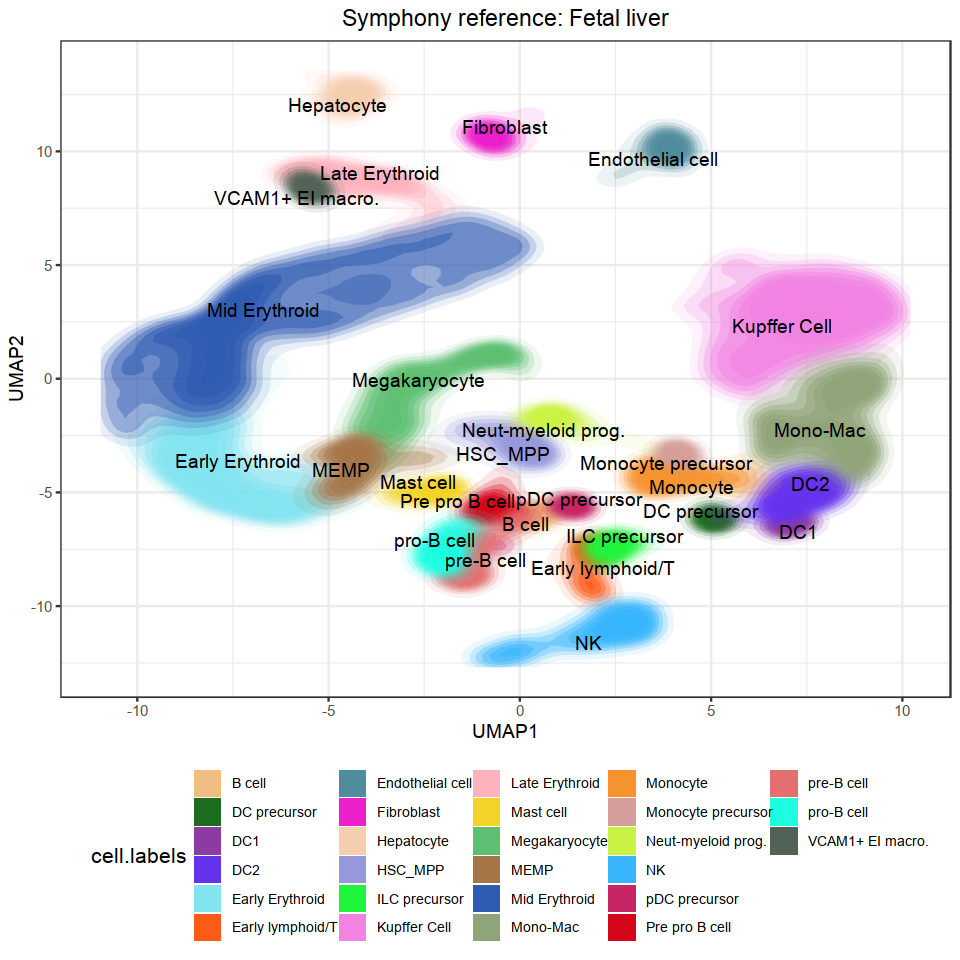

In [14]:
fig.size(8, 8)
p = plotReference(reference_fetal_liver,
                   as.density = TRUE,      # plot density or individual cells
                   bins = 10,              # if density, nbins parameter for stat_density_2d
                   bandwidth = 1.5,        # if density, bandwidth parameter for stat_density_2d
                   title = "Symphony reference: Fetal liver",    # Plot title
                   color.by = 'cell.labels', # metadata column name for cell type labels
                   celltype.colors = group.colors, # custom color palette
                   show.legend = TRUE,     # Show cell type legend
                   show.labels = TRUE,     # Show cell type labels
                   show.centroids = FALSE) # Plot soft cluster centroid locations)
p

## Map an example query dataset
We will map fetal liver cells sequenced with 10x 5' chemistry onto the atlas of cells sequenced with 3' chemistry.

In [15]:
exprs_5p = readRDS('../data/Fig5_fetal_liver/exprs_5sync_filtered.rds')
metadata_5p = readRDS('../data/Fig5_fetal_liver/metadata_5p_sync_filtered.rds') # from authors

In [16]:
metadata_5p$cell.labels = plyr::mapvalues(metadata_5p$cell.labels, 
    from = c('Neutrophil-myeloid progenitor', 'VCAM1+ EI macrophage'),
    to = c('Neut-myeloid prog.', 'VCAM1+ EI macro.')) # Shorter cell type labels
metadata_5p$end.bias = '5prime' # add covariate

In [17]:
dim(exprs_5p)
dim(metadata_5p)

[1] 33694 21414

[1] 21414    14

In [18]:
# Map query
ptm <- proc.time()
query = mapQuery(exprs_5p, metadata_5p, reference_fetal_liver, 
                 vars = c('donor', 'end.bias'), 
                 do_normalize = TRUE)
proc.time() - ptm

Normalizing
Scaling and synchronizing query gene expression
Found 1917 reference variable genes in query dataset
Project query cells using reference gene loadings
Clustering query cells to reference centroids
Correcting query batch effects
UMAP
All done!


   user  system elapsed 
 24.369   9.049  13.363 


Perform k-NN cell type prediction across 27 fine-grained continuous cell states

In [19]:
# Predict query cell types
query = knnPredict(query, reference_fetal_liver, 
                   train_labels = reference_fetal_liver$meta_data$cell.labels, 
                   k = 30)
# Prediction results are stored in query$meta_data$cell_type_pred_knn

In [20]:
query$meta_data %>% head(4)

index,cell_barcode,Source.Name,pcw,sex,organ,donor,trimester,facs.sorting,end.bias,num_cells,nGene,cell.labels.public,cell.labels,cell_type_pred_knn
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<int>,<int>,<fct>,<fct>,<fct>
FCAImmP7292028AAACCTGCACACTGCG,AAACCTGCACACTGCG,FCAImmP7292028,17 weeks gestation,female,liver,F16,Second trimister,Live/dead sorting,5prime,2223,2844,Early lymphoid_T lymphocyte,Early lymphoid/T,Early lymphoid/T
FCAImmP7292028AAACCTGCATATACGC,AAACCTGCATATACGC,FCAImmP7292028,17 weeks gestation,female,liver,F16,Second trimister,Live/dead sorting,5prime,2223,3572,Kupffer Cell,Kupffer Cell,Kupffer Cell
FCAImmP7292028AAACCTGGTACGACCC,AAACCTGGTACGACCC,FCAImmP7292028,17 weeks gestation,female,liver,F16,Second trimister,Live/dead sorting,5prime,2223,4644,Kupffer Cell,Kupffer Cell,Kupffer Cell
FCAImmP7292028AAACCTGGTAGGACAC,AAACCTGGTAGGACAC,FCAImmP7292028,17 weeks gestation,female,liver,F16,Second trimister,Live/dead sorting,5prime,2223,722,Late Erythroid,Late Erythroid,Late Erythroid


## Plot query after mapping

In [21]:
# Sync column names
r_metadata = reference_fetal_liver$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor', 'pcw')]
q_metadata = query$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor', 'pcw')]
colnames(q_metadata) = colnames(r_metadata)

r_metadata$ref_query = 'reference'
q_metadata$ref_query = q_metadata$donor
meta_data_combined = rbind(q_metadata, r_metadata)

In [22]:
# Add the UMAP coordinates to the metadata
colnames(query$umap) = c('UMAP1', 'UMAP2')
umap_combined = rbind(query$umap, reference_fetal_liver$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

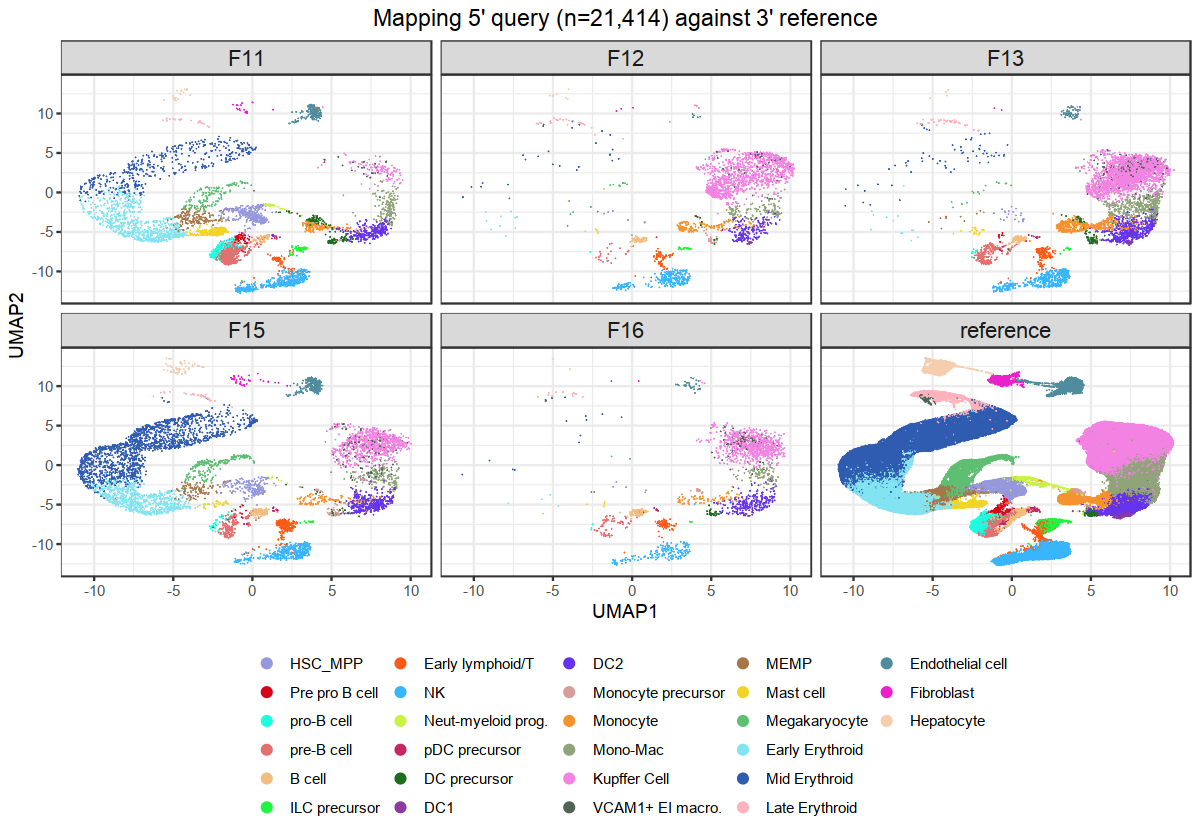

In [23]:
fig.size(7, 10)

q = umap_combined_labels %>%
    mutate(cell.labels = fct_relevel(cell.labels,  # Match original author publication ordering of states
            "HSC_MPP", "Pre pro B cell", 'pro-B cell', 'pre-B cell', 'B cell',
            'ILC precursor', 'Early lymphoid/T', 'NK', 'Neut-myeloid prog.',
            'pDC precursor','DC precursor', 'DC1', 'DC2', 'Monocyte precursor', 'Monocyte', 
            'Mono-Mac', 'Kupffer Cell', 'VCAM1+ EI macro.', 'MEMP', 'Mast cell',
            'Megakaryocyte', 'Early Erythroid', 'Mid Erythroid', 'Late Erythroid',
            'Endothelial cell', 'Fibroblast', 'Hepatocyte')) %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell.labels)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Mapping 5\' query (n=21,414) against 3\' reference', color = '') + 
    theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") +
    scale_colour_manual(values = group.colors) +
    guides(colour = guide_legend(override.aes = list(size = 3), ncol = 5)) +
    theme(strip.text.x = element_text(size=13)) +
    facet_wrap(~ref_query)
q